In [15]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim
from torch.optim import lr_scheduler

from classes.OCTADataset import OCTADataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import clip
from torchvision import transforms


In [16]:
full_dataset = OCTADataset(
    images_directory_root_path="/media/omerfarukaydin/747E76D67E76909A/Users/omerfarukaydin/data/OCTA-500",
    labels_directory_root_path="/media/omerfarukaydin/747E76D67E76909A/Users/omerfarukaydin/data/OCTA-500", 
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    num_classes=4
)

In [17]:
def show_image(image, label):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    channels = ['Channel 1 (R)', 'Channel 2 (G)', 'Channel 3 (B)']

    for i, ax in enumerate(axes):
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"{channels[i]} - Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # # Full RGB Visualization
    # plt.figure(figsize=(6, 6))
    # plt.imshow(image.permute(1, 2, 0))  # Rearrange (3, H, W) to (H, W, 3)
    # plt.title(f"Full RGB Image - Label: {label}")
    # plt.axis('off')
    # plt.show()

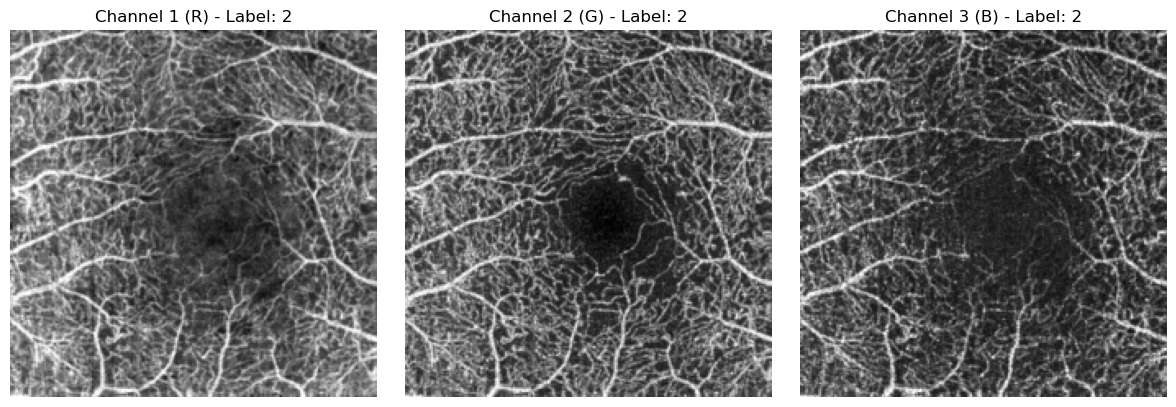

In [18]:
image, label = full_dataset[310]
show_image(image, label)

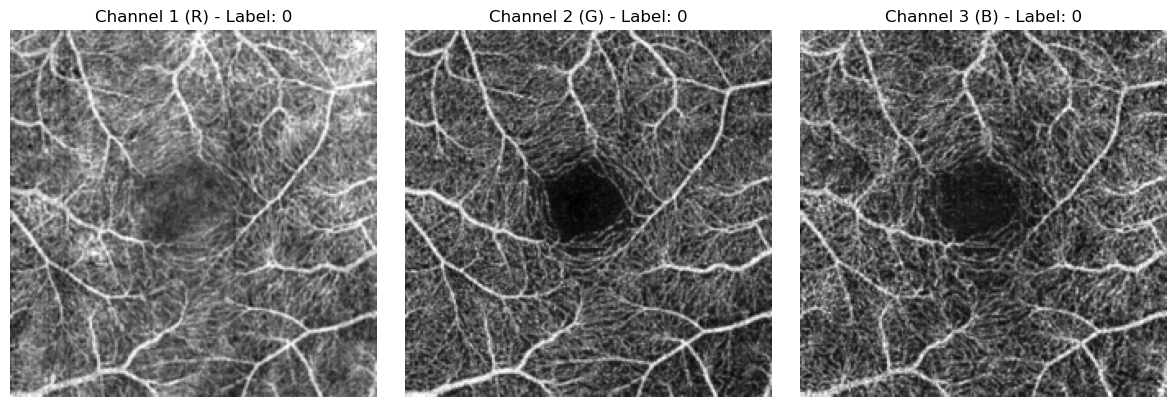

In [20]:
image, label = full_dataset[304]
show_image(image, label)

In [26]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

# CLIP Modelini Yükleme
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# OCTA Feature Dataset Sınıfı
class OCTAFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # CLIP preprocess ile görüntüyü hazırla
        image = preprocess(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, label

# OCTA Dataset Yükleme
octa_dataset = OCTADataset(
    images_directory_root_path="/media/omerfarukaydin/747E76D67E76909A/Users/omerfarukaydin/data/OCTA-500",
    labels_directory_root_path="/media/omerfarukaydin/747E76D67E76909A/Users/omerfarukaydin/data/OCTA-500", 
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    num_classes=4
)

# Feature Extraction Dataset ve DataLoader
feature_dataset = OCTAFeatureDataset(octa_dataset)
dataloader = DataLoader(feature_dataset, batch_size=64, shuffle=True)

# Linear Classifier
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, x):
        return self.classifier(x)

classifier = LinearClassifier(512, 4).to(device)  # CLIP'ten çıkan feature boyutu 512
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# Eğitim Döngüsü
for epoch in range(100):
    classifier.train()
    total_loss = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # CLIP Görsel Özelliklerini Çıkart
        with torch.no_grad():
            features = clip_model.get_image_features(images)
        
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(dataloader):.4f}")


Epoch [1/10], Loss: 1.5654
Epoch [2/10], Loss: 1.4919
Epoch [3/10], Loss: 1.4297
Epoch [4/10], Loss: 1.3774
Epoch [5/10], Loss: 1.3345
Epoch [6/10], Loss: 1.2990
Epoch [7/10], Loss: 1.2694
Epoch [8/10], Loss: 1.2485
Epoch [9/10], Loss: 1.2326
Epoch [10/10], Loss: 1.2210
Epoch [11/10], Loss: 1.2102
Epoch [12/10], Loss: 1.2055
Epoch [13/10], Loss: 1.1985
Epoch [14/10], Loss: 1.1963
Epoch [15/10], Loss: 1.1937
Epoch [16/10], Loss: 1.1945
Epoch [17/10], Loss: 1.1933
Epoch [18/10], Loss: 1.1914
Epoch [19/10], Loss: 1.1919
Epoch [20/10], Loss: 1.1918
Epoch [21/10], Loss: 1.1882
Epoch [22/10], Loss: 1.1901
Epoch [23/10], Loss: 1.1869
Epoch [24/10], Loss: 1.1884
Epoch [25/10], Loss: 1.1899
Epoch [26/10], Loss: 1.1876
Epoch [27/10], Loss: 1.1872
Epoch [28/10], Loss: 1.1878
Epoch [29/10], Loss: 1.1892
Epoch [30/10], Loss: 1.1872
Epoch [31/10], Loss: 1.1914
Epoch [32/10], Loss: 1.1864
Epoch [33/10], Loss: 1.1862
Epoch [34/10], Loss: 1.1916
Epoch [35/10], Loss: 1.1898
Epoch [36/10], Loss: 1.1901
E

KeyboardInterrupt: 

In [27]:
def test_model(model, dataloader, clip_model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Görsel Özelliklerini CLIP Encoder ile Çıkart
            features = clip_model.get_image_features(images)
            
            # Linear Layer ile Tahmin Yap
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            # Doğru tahmin sayısı
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [28]:
# Test için bir veri yükleyici oluştur
test_dataloader = DataLoader(feature_dataset, batch_size=16, shuffle=False)

# Modeli Test Et
test_model(classifier, test_dataloader, clip_model)


Test Accuracy: 50.20%
